## 1. Introduction

We have also used multi-layer feedforward neural network model, that we have used for non linear regression in A3, to compare the results of LSTM predictions. This helped us gain insight into the difference that recurrent connections and memory cells make. We downloaded datasets of daily stock prices Apple, AMD, Intel, Microsoft, Nvidia from yahoo finance website from 2018 to 2022 and loaded the data into pandas dataframes.The term ticker refers to a unique series of letters assigned to a security for trading purposes. It is a shorthand symbol or code used to uniquely identify a particular publicly traded company's stock on a stock exchange.

In [1]:
import pandas as pd

df1 = pd.read_csv('AAPL.csv')
df2 = pd.read_csv('AMD.csv')
df3 = pd.read_csv('INTC.csv')
df4 = pd.read_csv('MSFT.csv')
df5 = pd.read_csv('NVDA.csv')


In [2]:
df1

,Date,Open,High,Low,Close,Adj Close,Volume
0,2018-01-02,42.540001,43.075001,42.314999,43.064999,40.722866,102223600
1,2018-01-03,43.132500,43.637501,42.990002,43.057499,40.715794,118071600
2,2018-01-04,43.134998,43.367500,43.020000,43.257500,40.904907,89738400
3,2018-01-05,43.360001,43.842499,43.262501,43.750000,41.370621,94640000
4,2018-01-08,43.587502,43.902500,43.482498,43.587502,41.216953,82271200
...,...,...,...,...,...,...,...
1254,2022-12-23,130.919998,132.419998,129.639999,131.860001,131.127060,63814900
1255,2022-12-27,131.380005,131.410004,128.720001,130.029999,129.307236,69007800
1256,2022-12-28,129.669998,131.029999,125.870003,126.040001,125.339409,85438400
1257,2022-12-29,127.989998,130.479996,127.730003,129.610001,128.889572,75703700


The dataset has 7 columns Date, Opening price, Highest value, Lowest value, closing value, adjusted closing value, total number of shares traded during the day. We are training the model on date and Adjusted closing price and dropping other columns. Stock prices are affected by events like dividends, stock splits, and rights offerings. These events can distort historical prices and returns. The adjusted closing price normalizes these effects, providing a more accurate representation of the stock's true value, essential for predictive modeling and analyzing historical performance. For accurate analysis over time, especially for long-term investments, it's crucial to have consistent data. Adjusted prices ensure that historical data remains consistent despite corporate actions, enabling more reliable predictions and assessments of past performance.  

In [3]:
df1 = df1[['Date', 'Adj Close']]
df2 = df2[['Date', 'Adj Close']]
df3 = df3[['Date', 'Adj Close']]
df4 = df4[['Date', 'Adj Close']]
df5 = df5[['Date', 'Adj Close']]

str_to_datetime method takes a string in the format 'YYYY-MM-DD' representing a date and converts it into a datetime object. We convert the 'Date' column in each DataFrame to datetime objects and set the DataFrame index to this converted 'Date' column, essentially making the 'Date' column the index of each DataFrame.

In [4]:
import datetime

def str_to_datetime(s):
  split = s.split('-')
  year, month, day = int(split[0]), int(split[1]), int(split[2])
  return datetime.datetime(year=year, month=month, day=day)

datetime_object = str_to_datetime('2017-12-31')
datetime_object

datetime.datetime(2017, 12, 31, 0, 0)

In [5]:
df1['Date'] = df1['Date'].apply(str_to_datetime)
df1.index = df1.pop('Date')
df1

<ipython-input-5-721a01815551>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df1['Date'] = df1['Date'].apply(str_to_datetime)


,Adj Close
Date,
2018-01-02,40.722866
2018-01-03,40.715794
2018-01-04,40.904907
2018-01-05,41.370621
2018-01-08,41.216953
...,...
2022-12-23,131.127060
2022-12-27,129.307236
2022-12-28,125.339409


In [6]:
df2['Date'] = df2['Date'].apply(str_to_datetime)
df2.index = df2.pop('Date')
df3['Date'] = df3['Date'].apply(str_to_datetime)
df3.index = df3.pop('Date')
df4['Date'] = df4['Date'].apply(str_to_datetime)
df4.index = df4.pop('Date')
df5['Date'] = df5['Date'].apply(str_to_datetime)
df5.index = df5.pop('Date')

The graph below displays the daily stock prices fluctuations with time over the period of five years. 

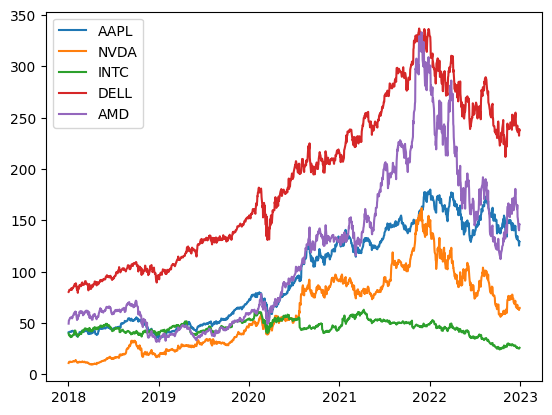

In [7]:
import matplotlib.pyplot as plt
plt.plot(df1.index, df1['Adj Close'], label="AAPL")
plt.plot(df2.index, df2['Adj Close'], label="NVDA")
plt.plot(df3.index, df3['Adj Close'], label="INTC")
plt.plot(df4.index, df4['Adj Close'], label="DELL")
plt.plot(df5.index, df5['Adj Close'], label="AMD")
plt.legend(['AAPL', 'NVDA', 'INTC', 'DELL', 'AMD'])

This is the multi-layer feedforward neural network model used Assignment 3.

In [8]:
%%writefile neuralnetworkA3.py

import numpy as np
import optimizers2 as opt


class NeuralNetwork():
    """
    A class that represents a neural network for nonlinear regression.

    Attributes
    ----------
    n_inputs : int
        The number of values in each sample
    n_hiddens_each_layer : list of ints, or empty
        The number of units in each hidden layer.
        Its length specifies the number of hidden layers.
    n_outputs : int
        The number of units in output layer
    all_weights : one-dimensional numpy array
        Contains all weights of the network as a vector
    Ws : list of two-dimensional numpy arrays
        Contains matrices of weights in each layer,
        as views into all_weights
    all_gradients : one-dimensional numpy array
        Contains all gradients of mean square error with
        respect to each weight in the network as a vector
    Grads : list of two-dimensional numpy arrays
        Contains matrices of gradients weights in each layer,
        as views into all_gradients
   error_trace : list of floats
        Mean square error (unstandardized) after each epoch
    n_epochs : int
        Number of epochs trained so far
    X_means : one-dimensional numpy array
        Means of the components, or features, across samples
    X_stds : one-dimensional numpy array
        Standard deviations of the components, or features, across samples
    T_means : one-dimensional numpy array
        Means of the components of the targets, across samples
    T_stds : one-dimensional numpy array
        Standard deviations of the components of the targets, across samples


    Methods
    -------
    _make_weights_and_views(shapes)
        Creates all initial weights and views for each layer

    train(Xtrain, Ttrain, Xvalidate, Tvalidate, n_epochs, method='sgd',
          learning_rate=None, momentum=0, weight_penalty=0, verbose=True)
        Trains the network using input and target samples by rows in Xtrain and Ttrain

    use(X)
        Applies network to inputs X and returns network's output
    """

    def __init__(self, n_inputs, n_hidden_each_layer, n_outputs):
        """Creates a neural network with the given structure

        Parameters
        ----------
        n_inputs : int
            The number of values in each sample
        n_hiddens_each_layer : list of ints, or empty
            The number of units in each hidden layer.
            Its length specifies the number of hidden layers.
        n_outputs : int
            The number of units in output layer

        Returns
        -------
        NeuralNetwork object
        """

        self.n_inputs = n_inputs
        self.n_hiddens_each_layer = n_hidden_each_layer
        self.n_outputs = n_outputs

        # Create list of shapes of weight matrices for each layer


        shapes = []
        n_in = n_inputs
        for nh in self.n_hiddens_each_layer:
            shapes.append((n_in + 1, nh))
            n_in = nh
        shapes.append((n_in + 1, n_outputs))
        # ...

        # Build one-dimensional vector of all weights and weight matrices
        # for each layer as views into this vector.
        # Call _make_weights_and_views to create all_weights and Ws
        self.all_weights, self.Ws = self._make_weights_and_views(shapes)

        # Call _make_weights_and_views to create all_gradients and Grads
        self.all_gradients, self.Grads = self._make_weights_and_views(shapes)


        self.X_means = None
        self.X_stds = None
        self.T_means = None
        self.T_stds = None

        self.n_epochs = 0
        self.error_trace = []


    def _make_weights_and_views(self, shapes):
        """Creates vector of all weights and views for each layer

        Parameters
        ----------
        shapes : list of pairs of ints
            Each pair is number of rows and columns of weights in each layer.
            Number of rows is number of inputs to layer (including constant 1).
            Number of columns is number of units, or outputs, in layer.

        Returns
        -------
        Vector of all weights, and list of views into this vector for each layer
        """

        # Create one-dimensional numpy array of all weights with random initial values between -1 and 1.

        #  ...
        all_weights = np.hstack([np.random.uniform(size=shape).flat / np.sqrt(shape[0])
                                 for shape in shapes])

        # Build weight matrices as list of views (pairs of number of rows and number
        # of columns) by reshaping corresponding elements from vector of all weights
        # into correct shape for each layer and dividing values of each weight matrix
        # by the square root of number of its inputs. Remember to use /=

        # ...
        views = []
        start = 0
        for shape in shapes:
            size =shape[0] * shape[1]
            view = all_weights[start:start + size].reshape(shape)
            view /= np.sqrt(shape[0])
            views.append(view)
            start += size
        # Set output layer weights to zero.

        # ...


        for i in range(len(views[-1])):
            views[-1][i] = 0
        return all_weights, views

    def __repr__(self):
        return f'NeuralNetwork({self.n_inputs}, {self.n_hiddens_each_layer}, {self.n_outputs})'

    def __str__(self):
        if self.n_epochs is not None:
            return f'{self.__repr__()} trained for {self.n_epochs} epochs with a final RMSE of {self.rmse}.'
        else:
            return f'{self.__repr__()} has not been trained.'


    def train(self, Xtrain, Ttrain, Xvalidate, Tvalidate, n_epochs,
              method='sgd', learning_rate=None, momentum=0, weight_penalty=0, verbose=True):
        """Updates the weights.

        Parameters
        ----------
        Xtrain : two-dimensional numpy array
            number of training samples  by  number of input components
        Ttrain : two-dimensional numpy array
            number of training samples  by  number of output components
        Xvalidate : two-dimensional numpy array
            number of validation samples  by  number of input components
        Tvalidate : two-dimensional numpy array
            number of validationg samples  by  number of output components
        n_epochs : int
            Number of passes to take through all samples
        method : str
            'sgd', 'adam', or 'scg'
        learning_rate : float
            Controls the step size of each update, only for sgd and adam
        momentum : float
            Controls amount of previous weight update to add to current weight update, only for sgd
        weight_penalty : float
            Controls amount to penalize large magnitude weights
        verbose: boolean
            If True, progress is shown with print statements
        """

        # Calculate and assign standardization parameters

        # ...
        if self.X_means is None:
            self.X_means = Xtrain.mean(axis=0)
            self.X_stds = Xtrain.std(axis=0)
            self.X_stds[self.X_stds == 0] = 1  # So we don't divide by zero when standardizing
            self.T_means = Ttrain.mean(axis=0)
            self.T_stds = Ttrain.std(axis=0)

        # Standardize Xtrain, Ttrain, Xvalidate and Tvalidate.

        # ...
        Xtrain = (Xtrain - self.X_means) / self.X_stds
        Ttrain = (Ttrain - self.T_means) / self.T_stds

        Xvalidate = (Xvalidate - self.X_means) / self.X_stds
        Tvalidate = (Tvalidate - self.T_means) / self.T_stds

        # Instantiate Optimizers object by giving it vector of all weights

        optimizer = opt.Optimizers(self.all_weights)

        # Define function to convert mean-square error to root-mean-square error,
        # Here we use a lambda function just to illustrate its use.
        # We could have also defined this function with
        # def error_convert_f(err):
        #     return np.sqrt(err)

        error_convert_f = lambda err: np.sqrt(err)

        # Call the requested optimizer method to train the weights.

        if method == 'sgd':

            self.error_trace = optimizer.sgd(Xtrain, Ttrain, Xvalidate, Tvalidate,
                                             self.error_f, self.gradient_f,
                                             n_epochs=n_epochs, learning_rate=learning_rate,
                                             momentum=momentum, weight_penalty=weight_penalty,
                                             verbose=True)


        elif method == 'adamw':

            self.error_trace = optimizer.adamw(Xtrain, Ttrain, Xvalidate, Tvalidate,
                                               self.error_f, self.gradient_f,
                                               n_epochs=n_epochs, learning_rate=learning_rate,
                                               weight_penalty=weight_penalty,
                                               verbose=True)

        elif method == 'scg':

            self.error_trace = optimizer.scg(Xtrain, Ttrain, Xvalidate, Tvalidate,
                                             self.error_f, self.gradient_f,
                                             n_epochs=n_epochs,
                                             weight_penalty=weight_penalty,
                                             verbose=True)

        else:
            raise Exception("method must be 'sgd', 'adam', or 'scg'")

        self.n_epochs += len(self.error_trace)
        self.best_epoch = optimizer.best_epoch

        # Return neural network object to allow applying other methods
        # after training, such as:    Y = nnet.train(X, T, 100, 0.01).use(X)

        return self

    def _add_ones(self, X):
        return np.insert(X, 0, 1, 1)

    def _forward(self, X):
        """Calculate outputs of each layer given inputs in X.

        Parameters
        ----------
        X : input samples, standardized.

        Returns
        -------
        Standardized outputs of all layers as list, include X as first element.
        """

        self.Zs = [X]

        # Append output of each layer to list in self.Zs, then return it.

        # ...
        for W in self.Ws[:-1]:
            self.Zs.append(np.tanh(self._add_ones(self.Zs[-1]) @ W)) #W[1:, :] + W[0:1, :]))
        last_W = self.Ws[-1]
        self.Zs.append(self._add_ones(self.Zs[-1]) @ last_W)# [1:, :] + last_W[0:1, :])
        return self.Zs

    # Function to be minimized by optimizer method, mean squared error
    def error_f(self, X, T):
        """Calculate output of net given input X and its mean squared error.
        Function to be minimized by optimizer.

        Parameters
        ----------
        X : two-dimensional numpy array, standardized
            number of samples  by  number of input components
        T : two-dimensional numpy array, standardized
            number of samples  by  number of output components

        Returns
        -------
        Standardized mean square error as scalar float that is the mean
        square error over all samples and all network outputs.
        """
        # Call _forward, calculate mean square error and return it.

        # ...
        Ys = self._forward(X)
        mean_sq_error = np.mean((T - Ys[-1]) ** 2)
        return mean_sq_error

    # Gradient of function to be minimized for use by optimizer method
    def gradient_f(self, X, T):
        """Returns gradient wrt all weights. Assumes _forward already called
        so input and all layer outputs stored in self.Zs

        Parameters
        ----------
        X : two-dimensional numpy array, standardized
            number of samples  x  number of input components
        T : two-dimensional numpy array, standardized
            number of samples  x  number of output components

        Returns
        -------
        Vector of gradients of mean square error wrt all weights
        """

        # Assumes forward_pass just called with layer outputs saved in self.Zs.

        n_samples = X.shape[0]
        n_outputs = T.shape[1]
        n_layers = len(self.n_hiddens_each_layer) + 1

        # delta is delta matrix to be back propagated.
        # Dividing by n_samples and n_outputs here replaces the scaling of
        # the learning rate.

        delta = -(T - self.Zs[-1]) / (n_samples * n_outputs)

        # Step backwards through the layers to back-propagate the error (delta)

        for layeri in range(n_layers - 1, -1, -1):
            # gradient of all but bias weights
            self.Grads[layeri][1:] = self.Zs[layeri].T @ delta
            self.Grads[layeri][0:1, :] = np.sum(delta, 0)

           # Back-propagate this layer's delta to previous layer
            if layeri > 0:
                delta = delta @ self.Ws[layeri][1:, :].T * (1 - self.Zs[layeri] ** 2)

        return self.all_gradients

    def use(self, X):
        """Return the output of the network for input samples as rows in X.
        X assumed to not be standardized.

        Parameters
        ----------
        X : two-dimensional numpy array
            number of samples  by  number of input components, unstandardized

        Returns
        -------
        Output of neural network, unstandardized, as numpy array
        of shape  number of samples  by  number of outputs
        """

        # Standardize X

        # ...
        Xstds1 = (X - self.X_means) / self.X_stds

        # Call _forward to get the neural network's output

        # ...
        y = self._forward(Xstds1)
        y = y[-1]

        # Unstandardize output Y before returning it
        y = y * self.T_stds + self.T_means
        return y

    def get_error_trace(self):
        """Returns list of root-mean square error for each epoch"""
        return self.error_trace

Overwriting neuralnetworkA3.py


In [9]:
%load_ext autoreload
%autoreload 2

import numpy as np
import matplotlib.pyplot as plt

import neuralnetworkA3 as nn

In [10]:
# from sklearn.preprocessing import MinMaxScaler
# scaler = MinMaxScaler()

In [11]:
# for df in dataframes:
#     # normalizing dataset
#     norm_act_adj_close = scaler.fit_transform(np.array(adj_close_df[df]).reshape(-1, 1))

This method, df_to_windowed_df, takes a DataFrame of stock data, along with a specified time window, and creates a windowed dataset suitable for training a predictive model. It converts the provided date strings to datetime objects using the str_to_datetime function and sets the target_date initially as the first_date. It iterates through the data, creating a windowed dataset by:
1. Fetching a subset of the DataFrame up to the target_date with a window size of n+1.
2. Extracting 'Adj Close' values from this subset, where the last value is the target 'Y', and the preceding n values are used as input 'X'.
3. Appending these 'X' and 'Y' values to separate lists (dates, X, and Y).
4. Determining the next date in the sequence by adding 7 days to the current target_date.
It returns the constructed DataFrame ret_df, which contains windowed data suitable for training a model where each row represents a window of 'X' values (previous 'Adj Close' values) and the corresponding 'Y' value (next 'Adj Close') to predict.
We are using this method to preprocess dataframes of the 5 stocks.

In [12]:
def df_to_windowed_df(dataframe, first_date_str, last_date_str, n=3):
  first_date = str_to_datetime(first_date_str)
  last_date  = str_to_datetime(last_date_str)

  target_date = first_date

  dates = []
  X, Y = [], []

  last_time = False
  while True:
    df_subset = dataframe.loc[:target_date].tail(n+1)

    if len(df_subset) != n+1:
      print(f'Error: Window of size {n} is too large for date {target_date}')
      return

    values = df_subset['Adj Close'].to_numpy()
    x, y = values[:-1], values[-1]

    dates.append(target_date)
    X.append(x)
    Y.append(y)

    next_week = dataframe.loc[target_date:target_date+datetime.timedelta(days=7)]
    next_datetime_str = str(next_week.head(2).tail(1).index.values[0])
    next_date_str = next_datetime_str.split('T')[0]
    year_month_day = next_date_str.split('-')
    year, month, day = year_month_day
    next_date = datetime.datetime(day=int(day), month=int(month), year=int(year))

    if last_time:
      break

    target_date = next_date

    if target_date == last_date:
      last_time = True

  ret_df = pd.DataFrame({})
  ret_df['Target Date'] = dates

  X = np.array(X)
  for i in range(0, n):
    X[:, i]
    ret_df[f'Target-{n-i}'] = X[:, i]

  ret_df['Target'] = Y

  return ret_df



In [13]:
windowed_df1 = df_to_windowed_df(df1,
                                '2018-01-05',
                                '2022-12-30',
                                n=3)
windowed_df1

,Target Date,Target-3,Target-2,Target-1,Target
0,2018-01-05,40.722866,40.715794,40.904907,41.370621
1,2018-01-08,40.715794,40.904907,41.370621,41.216953
2,2018-01-09,40.904907,41.370621,41.216953,41.212223
3,2018-01-10,41.370621,41.216953,41.212223,41.202774
4,2018-01-11,41.216953,41.212223,41.202774,41.436813
...,...,...,...,...,...
1251,2022-12-23,131.564606,134.697098,131.494995,131.127060
1252,2022-12-27,134.697098,131.494995,131.127060,129.307236
1253,2022-12-28,131.494995,131.127060,129.307236,125.339409
1254,2022-12-29,131.127060,129.307236,125.339409,128.889572


In [14]:
windowed_df2 = df_to_windowed_df(df2,
                                '2018-01-05',
                                '2022-12-30',
                                n=3)
windowed_df2

,Target Date,Target-3,Target-2,Target-1,Target
0,2018-01-05,10.980000,11.550000,12.120000,11.880000
1,2018-01-08,11.550000,12.120000,11.880000,12.280000
2,2018-01-09,12.120000,11.880000,12.280000,11.820000
3,2018-01-10,11.880000,12.280000,11.820000,11.960000
4,2018-01-11,12.280000,11.820000,11.960000,12.140000
...,...,...,...,...,...
1251,2022-12-23,65.050003,67.680000,63.860001,64.519997
1252,2022-12-27,67.680000,63.860001,64.519997,63.270000
1253,2022-12-28,63.860001,64.519997,63.270000,62.570000
1254,2022-12-29,64.519997,63.270000,62.570000,64.820000


In [15]:
windowed_df3 = df_to_windowed_df(df3,
                                '2018-01-05',
                                '2022-12-30',
                                n=3)
windowed_df3

,Target Date,Target-3,Target-2,Target-1,Target
0,2018-01-05,39.857136,38.504448,37.798336,38.062065
1,2018-01-08,38.504448,37.798336,38.062065,38.062065
2,2018-01-09,37.798336,38.062065,38.062065,37.109241
3,2018-01-10,38.062065,38.062065,37.109241,36.156422
4,2018-01-11,38.062065,37.109241,36.156422,36.930584
...,...,...,...,...,...
1251,2022-12-23,25.836962,26.218069,25.377680,25.494944
1252,2022-12-27,26.218069,25.377680,25.494944,25.348366
1253,2022-12-28,25.377680,25.494944,25.348366,24.957489
1254,2022-12-29,25.494944,25.348366,24.957489,25.612206


In [16]:
windowed_df4 = df_to_windowed_df(df4,
                                '2018-01-05',
                                '2022-12-30',
                                n=3)
windowed_df4

,Target Date,Target-3,Target-2,Target-1,Target
0,2018-01-05,80.229012,80.602386,81.311790,82.319916
1,2018-01-08,80.602386,81.311790,82.319916,82.403915
2,2018-01-09,81.311790,82.319916,82.403915,82.347908
3,2018-01-10,82.319916,82.403915,82.347908,81.974518
4,2018-01-11,82.403915,82.347908,81.974518,82.217239
...,...,...,...,...,...
1251,2022-12-23,239.674820,242.281693,236.096558,236.631805
1252,2022-12-27,242.281693,236.096558,236.631805,234.877380
1253,2022-12-28,236.096558,236.631805,234.877380,232.468719
1254,2022-12-29,236.631805,234.877380,232.468719,238.891769


In [17]:
windowed_df5 = df_to_windowed_df(df5,
                                '2018-01-05',
                                '2022-12-30',
                                n=3)
windowed_df5

,Target Date,Target-3,Target-2,Target-1,Target
0,2018-01-05,49.312782,52.558262,52.835300,53.283047
1,2018-01-08,52.558262,52.835300,53.283047,54.915676
2,2018-01-09,52.835300,53.283047,54.915676,54.900833
3,2018-01-10,53.283047,54.915676,54.900833,55.331238
4,2018-01-11,54.915676,54.900833,55.331238,55.430191
...,...,...,...,...,...
1251,2022-12-23,160.778671,164.936798,153.321960,151.992554
1252,2022-12-27,164.936798,153.321960,151.992554,141.147385
1253,2022-12-28,153.321960,151.992554,141.147385,140.297745
1254,2022-12-29,151.992554,141.147385,140.297745,145.965240


"windowed_df_to_date_X_y" method takes a windowed DataFrame generated from stock data and transforms it into three arrays: dates, input data 'X', and target data 'Y' suitable for training a model. Converts the DataFrame into a NumPy array (df_as_np) to facilitate array operations. It extracts the dates from the first column of the array (df_as_np[:, 0]) and stores them in a separate array (dates). Removes the first and last columns (dates and target 'Y') from the array to isolate the input 'X' values, and reshapes this middle portion into a three-dimensional array (X) where: The first dimension represents the number of samples or dates. The second dimension signifies the window size or the number of input features. The third dimension (set to 1) is added to meet the requirement of some neural network libraries that expect a three-dimensional input. Extracts the last column of the array as the target 'Y' (df_as_np[:, -1]) and stores it separately. 

In [18]:
def windowed_df_to_date_X_y(windowed_dataframe):
  df_as_np = windowed_dataframe.to_numpy()

  dates = df_as_np[:, 0]

  middle_matrix = df_as_np[:, 1:-1]
  X = middle_matrix.reshape((len(dates), middle_matrix.shape[1], 1))

  Y = df_as_np[:, -1]

  return dates, X.astype(np.float32), Y.astype(np.float32)


In [19]:
dates1, X_1, y_1 = windowed_df_to_date_X_y(windowed_df1)
dates2, X_2, y_2 = windowed_df_to_date_X_y(windowed_df2)
dates3, X_3, y_3 = windowed_df_to_date_X_y(windowed_df3)
dates4, X_4, y_4 = windowed_df_to_date_X_y(windowed_df4)
dates5, X_5, y_5 = windowed_df_to_date_X_y(windowed_df5)

In [20]:
# for df in dataframes:
#   dates, X, y = windowed_df_to_date_X_y(df)
#   results.append([dates, X, y])
#   print(dates.shape, X.shape, y.shape)
#results

In [21]:
print(dates1.shape, X_1.shape, y_1.shape)
print(dates2.shape, X_2.shape, y_2.shape)
print(dates3.shape, X_3.shape, y_3.shape)
print(dates4.shape, X_4.shape, y_4.shape)
print(dates5.shape, X_5.shape, y_5.shape)

(1256,) (1256, 3, 1) (1256,)
(1256,) (1256, 3, 1) (1256,)
(1256,) (1256, 3, 1) (1256,)
(1256,) (1256, 3, 1) (1256,)
(1256,) (1256, 3, 1) (1256,)


In [22]:
X1 = np.squeeze(X_1, axis=-1)
X2 = np.squeeze(X_2, axis=-1)
X3 = np.squeeze(X_3, axis=-1)
X4 = np.squeeze(X_4, axis=-1)
X5 = np.squeeze(X_5, axis=-1)
y1 = y_1.reshape(-1,1)
y2 = y_2.reshape(-1,1)
y3 = y_3.reshape(-1,1)
y4 = y_4.reshape(-1,1)
y5 = y_5.reshape(-1,1)

In [23]:
print(y1.shape, y2.shape, y3.shape, X4.shape, X5.shape)

(1256, 1) (1256, 1) (1256, 1) (1256, 3) (1256, 3)


In [24]:
dates1

array([Timestamp('2018-01-05 00:00:00'), Timestamp('2018-01-08 00:00:00'),
       Timestamp('2018-01-09 00:00:00'), ...,
       Timestamp('2022-12-28 00:00:00'), Timestamp('2022-12-29 00:00:00'),
       Timestamp('2022-12-30 00:00:00')], dtype=object)

We are splitting the data where 80% of data is for training and 20% is for testing for all the 5 stocks. 

In [25]:
def split_data(dates, X, y, split_ratio=0.8):
    q = int(len(dates) * split_ratio)
    dates_train, X_train, y_train = dates[:q], X[:q], y[:q]
    dates_val, X_val, y_val = dates[q:], X[q:], y[q:]
    return dates_train, X_train, y_train, dates_val, X_val, y_val

In [26]:
dates1_train, X1_train, y1_train, dates1_val, X1_val, y1_val = split_data(dates1, X1, y1)
dates2_train, X2_train, y2_train, dates2_val, X2_val, y2_val = split_data(dates2, X2, y2)
dates3_train, X3_train, y3_train, dates3_val, X3_val, y3_val = split_data(dates3, X3, y3)
dates4_train, X4_train, y4_train, dates4_val, X4_val, y4_val = split_data(dates4, X4, y4)
dates5_train, X5_train, y5_train, dates5_val, X5_val, y5_val = split_data(dates5, X5, y5)

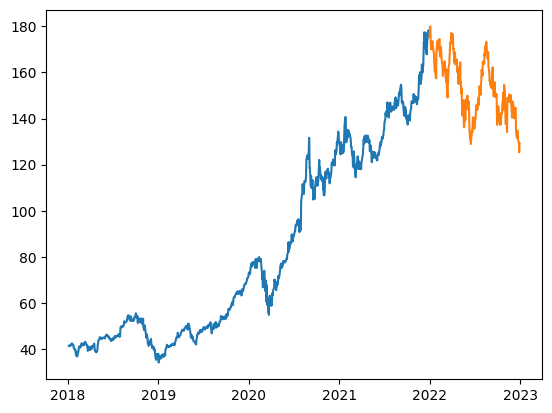

In [27]:
plt.plot(dates1_train, y1_train)
plt.plot(dates1_val, y1_val)

In [30]:
def rmse(T, Y):
    return np.sqrt(np.mean((T - Y)**2))

This method, run_experiment, performs an experiment to train neural network models with different configurations and hyperparameters and records their performance metrics. We ran the experiments with epochs 1000,2000, 3000, learning rate 0.01, hidden units per layer [10], [10, 10, 10], [50, 50], [50, 50, 50] and optimizers adam,scg

In [48]:
def run_experiment(X_train, y_train, X_val, y_val, n_epochs_choices, learning_rate, n_hidden_units_per_layer_choices, method_choices):
    results = []
    #Xtrain, Ttrain, Xvalidate, Tvalidate, Xtest, Ttest = partition(X, T, train_validation_test_fractions)


    for epochs in n_epochs_choices: # Training durations
        for nh in n_hidden_units_per_layer_choices: # Layer sizes
            for method in method_choices: # Optimizers
                nnet = nn.NeuralNetwork(X_train.shape[1], nh, y_train.shape[1])

                nnet.train(X_train, y_train, X_val, y_val, epochs, method, learning_rate, momentum=0.9, weight_penalty=0, verbose=True)
            # append the  results of each experiment
                train_e = rmse(y_train, nnet.use(X_train))
                validate_e = rmse(y_val, nnet.use(X_val))
                # train_predictions = nnet.use(X_train)
                # val_predictions = nnet.use(X_val)
                #test_e = rmse(Ttest, nnet.use(Xtest))
                results.append([nh, epochs, learning_rate, method, train_e, validate_e])

            # load these into a dataframe and give it some column titles
    # plt.plot(dates1_train, X_train, label='Actual Price')
    # plt.plot(dates1_train, train_predictions, label='Predicted Price')

    final_df = pd.DataFrame(results, columns=['structure', 'epochs', 'learning rate', 'method', 'RMSE Train','RMSE Val'])
    #final_df = pandas.DataFrame(results, columns=['epochs', 'nh', 'lr', 'RMSE Train', 'RMSE Val', 'RMSE Test'])
    print(final_df)
    return final_df

In [50]:
result11_df = run_experiment(X1_train, y1_train, X1_val, y1_val, n_epochs_choices=[1000, 2000, 3000], learning_rate= 0.01, n_hidden_units_per_layer_choices=[[10], [10, 10, 10], [50, 50], [50, 50, 50]], method_choices=['adamw','scg'])

AdamW: Epoch 100 MSE=0.00887,0.05508
AdamW: Epoch 200 MSE=0.00535,0.02239
AdamW: Epoch 300 MSE=0.00417,0.01550
AdamW: Epoch 400 MSE=0.00348,0.01239
AdamW: Epoch 500 MSE=0.00300,0.01051
AdamW: Epoch 600 MSE=0.00265,0.00924
AdamW: Epoch 700 MSE=0.00236,0.00829
AdamW: Epoch 800 MSE=0.00213,0.00757
AdamW: Epoch 900 MSE=0.00199,0.00722
AdamW: Epoch 1000 MSE=0.00194,0.00717
SCG: Epoch 100 MSE=0.00199,0.00704
SCG: Epoch 200 MSE=0.00197,0.00703
SCG: Epoch 300 MSE=0.00193,0.00700
SCG: Epoch 400 MSE=0.00193,0.00700
SCG: Epoch 500 MSE=0.00193,0.00701
SCG: Epoch 600 MSE=0.00192,0.00700
SCG: Epoch 700 MSE=0.00192,0.00699
SCG: Epoch 800 MSE=0.00191,0.00700
SCG: Epoch 900 MSE=0.00191,0.00699
SCG: Epoch 1000 MSE=0.00191,0.00700
AdamW: Epoch 100 MSE=0.01161,0.06570
AdamW: Epoch 200 MSE=0.00469,0.02085
AdamW: Epoch 300 MSE=0.00370,0.01398
AdamW: Epoch 400 MSE=0.00318,0.01171
AdamW: Epoch 500 MSE=0.00297,0.01064
AdamW: Epoch 600 MSE=0.00343,0.00867
AdamW: Epoch 700 MSE=0.00269,0.00933
AdamW: Epoch 800 MS

In [51]:
sort_val11 = result11_df.sort_values(by='RMSE Val', inplace=False)
sort_val11

,structure,epochs,learning rate,method,RMSE Train,RMSE Val
17,[10],3000,0.01,scg,1.769767,3.356095
11,"[10, 10, 10]",2000,0.01,scg,1.777584,3.357355
1,[10],1000,0.01,scg,1.759542,3.360256
9,[10],2000,0.01,scg,1.765948,3.360332
19,"[10, 10, 10]",3000,0.01,scg,1.764931,3.365908
3,"[10, 10, 10]",1000,0.01,scg,1.790168,3.368601
13,"[50, 50]",2000,0.01,scg,1.760088,3.368602
15,"[50, 50, 50]",2000,0.01,scg,1.786700,3.369049
7,"[50, 50, 50]",1000,0.01,scg,1.761069,3.372388
23,"[50, 50, 50]",3000,0.01,scg,1.756007,3.380438


From the experiment, configurations with smaller structures, specifically [10], tended to perform better in terms of RMSE on both training and validation sets across different epochs and methods. However, there were fluctuations in performance across different configurations, with larger structures like [50, 50, 50] exhibiting higher RMSE values, especially when using the 'adamw' optimizer. The choice of optimizer and structure greatly affected the model's performance, with smaller structures and 'scg' optimizer consistently showing more competitive performance across the experiments.

In this experiment we are training with learning rate as 0.02, hidden units per layer [20], [20, 20], [20, 20, 20] and optimzer as scg keeping number of epochs same as previous experiment.  

In [54]:
result12_df = run_experiment(X1_train, y1_train, X1_val, y1_val, n_epochs_choices=[1000, 2000, 3000], learning_rate= 0.02, n_hidden_units_per_layer_choices=[[20], [20, 20], [20, 20, 20]], method_choices=['scg'])

SCG: Epoch 100 MSE=0.00197,0.00698
SCG: Epoch 200 MSE=0.00194,0.00701
SCG: Epoch 300 MSE=0.00194,0.00701
SCG: Epoch 400 MSE=0.00193,0.00702
SCG: Epoch 500 MSE=0.00192,0.00704
SCG: Epoch 600 MSE=0.00191,0.00703
SCG: Epoch 700 MSE=0.00191,0.00702
SCG: Epoch 800 MSE=0.00191,0.00701
SCG: Epoch 900 MSE=0.00190,0.00702
SCG: Epoch 1000 MSE=0.00190,0.00702
SCG: Epoch 100 MSE=0.00194,0.00726
SCG: Epoch 200 MSE=0.00193,0.00711
SCG: Epoch 300 MSE=0.00192,0.00723
SCG: Epoch 400 MSE=0.00192,0.00710
SCG: Epoch 500 MSE=0.00191,0.00719
SCG: Epoch 600 MSE=0.00191,0.00711
SCG: Epoch 700 MSE=0.00191,0.00710
SCG: Epoch 800 MSE=0.00190,0.00709
SCG: Epoch 900 MSE=0.00190,0.00708
SCG: Epoch 1000 MSE=0.00190,0.00711
SCG: Epoch 100 MSE=0.00194,0.00714
SCG: Epoch 200 MSE=0.00192,0.00711
SCG: Epoch 300 MSE=0.00192,0.00719
SCG: Epoch 400 MSE=0.00192,0.00715
SCG: Epoch 500 MSE=0.00191,0.00716
SCG: Epoch 600 MSE=0.00191,0.00705
SCG: Epoch 700 MSE=0.00190,0.00709
SCG: Epoch 800 MSE=0.00190,0.00708
SCG: Epoch 900 MSE

In [55]:
sort_val12 = result12_df.sort_values(by='RMSE Val', inplace=False)
sort_val12

,structure,epochs,learning rate,method,RMSE Train,RMSE Val
0,[20],1000,0.02,scg,1.785695,3.353606
3,[20],2000,0.02,scg,1.784581,3.356999
6,[20],3000,0.02,scg,1.759259,3.359603
8,"[20, 20, 20]",3000,0.02,scg,1.777675,3.361128
7,"[20, 20]",3000,0.02,scg,1.757347,3.362222
4,"[20, 20]",2000,0.02,scg,1.781364,3.372380
1,"[20, 20]",1000,0.02,scg,1.780508,3.374578
2,"[20, 20, 20]",1000,0.02,scg,1.786500,3.376096
5,"[20, 20, 20]",2000,0.02,scg,1.760397,3.379543


The results showcase the performance of neural networks with varying structures, epochs, and a learning rate of 0.02 using the 'scg' optimization method. Across different structures, increasing epochs generally showed a slight improvement in training and validation RMSE, with [20] structures demonstrating competitive performance and lower validation error, notably at 3000 epochs. The configurations with larger structures like [20, 20, 20] showcased similar performance trends but slightly higher RMSE values across both training and validation sets.

In [56]:
result21_df = run_experiment(X2_train, y2_train, X2_val, y2_val, n_epochs_choices=[1000, 2000, 3000], learning_rate= 0.01, n_hidden_units_per_layer_choices=[[10], [10, 10, 10], [50, 50], [50, 50, 50]], method_choices=['adamw','scg'])

AdamW: Epoch 100 MSE=0.01299,0.02018
AdamW: Epoch 200 MSE=0.00697,0.01728
AdamW: Epoch 300 MSE=0.00530,0.01505
AdamW: Epoch 400 MSE=0.00439,0.01332
AdamW: Epoch 500 MSE=0.00382,0.01227
AdamW: Epoch 600 MSE=0.00338,0.01162
AdamW: Epoch 700 MSE=0.00304,0.01126
AdamW: Epoch 800 MSE=0.00295,0.01120
AdamW: Epoch 900 MSE=0.00295,0.01117
AdamW: Epoch 1000 MSE=0.00294,0.01114
SCG: Epoch 100 MSE=0.00307,0.01081
SCG: Epoch 200 MSE=0.00304,0.01075
SCG: Epoch 300 MSE=0.00303,0.01074
SCG: Epoch 400 MSE=0.00302,0.01071
SCG: Epoch 500 MSE=0.00301,0.01071
SCG: Epoch 600 MSE=0.00301,0.01071
SCG: Epoch 700 MSE=0.00300,0.01068
SCG: Epoch 800 MSE=0.00300,0.01066
SCG: Epoch 900 MSE=0.00300,0.01066
SCG: Epoch 1000 MSE=0.00300,0.01066
AdamW: Epoch 100 MSE=0.01400,0.01916
AdamW: Epoch 200 MSE=0.00699,0.01166
AdamW: Epoch 300 MSE=0.00554,0.01634
AdamW: Epoch 400 MSE=0.00453,0.01226
AdamW: Epoch 500 MSE=0.00435,0.01111
AdamW: Epoch 600 MSE=0.00819,0.01974
AdamW: Epoch 700 MSE=0.00390,0.01217
AdamW: Epoch 800 MS

In [57]:
sort_val21 = result21_df.sort_values(by='RMSE Val', inplace=False)
sort_val21

,structure,epochs,learning rate,method,RMSE Train,RMSE Val
6,"[50, 50, 50]",1000,0.01,adamw,2.540806,3.640818
3,"[10, 10, 10]",1000,0.01,scg,2.106928,3.668866
15,"[50, 50, 50]",2000,0.01,scg,2.144033,3.677858
17,[10],3000,0.01,scg,2.063364,3.680686
19,"[10, 10, 10]",3000,0.01,scg,2.061830,3.690832
1,[10],1000,0.01,scg,2.045472,3.691530
11,"[10, 10, 10]",2000,0.01,scg,1.974134,3.692438
9,[10],2000,0.01,scg,1.961795,3.698593
13,"[50, 50]",2000,0.01,scg,1.966132,3.713441
7,"[50, 50, 50]",1000,0.01,scg,2.007610,3.716704


The results depict the performance of neural networks with different structures, epochs, and a learning rate of 0.01 using 'scg' and 'adamw' optimization methods. Models with structures like [10] and [10, 10, 10], particularly with 2000 to 3000 epochs, showcased lower training and validation RMSE across both optimization methods. However, larger structures like [50, 50, 50] struggled to generalize, exhibiting higher RMSE values, especially under the 'adamw' optimization method.

In [58]:
result22_df = run_experiment(X2_train, y2_train, X2_val, y2_val, n_epochs_choices=[1000, 2000, 3000], learning_rate= 0.02, n_hidden_units_per_layer_choices=[[20], [20, 20], [20, 20, 20]], method_choices=['scg'])

SCG: Epoch 100 MSE=0.00304,0.01078
SCG: Epoch 200 MSE=0.00302,0.01074
SCG: Epoch 300 MSE=0.00302,0.01063
SCG: Epoch 400 MSE=0.00301,0.01068
SCG: Epoch 500 MSE=0.00300,0.01067
SCG: Epoch 600 MSE=0.00300,0.01067
SCG: Epoch 700 MSE=0.00300,0.01065
SCG: Epoch 800 MSE=0.00299,0.01065
SCG: Epoch 900 MSE=0.00299,0.01069
SCG: Epoch 1000 MSE=0.00298,0.01074
SCG: Epoch 100 MSE=0.00299,0.01086
SCG: Epoch 200 MSE=0.00298,0.01090
SCG: Epoch 300 MSE=0.00297,0.01089
SCG: Epoch 400 MSE=0.00297,0.01093
SCG: Epoch 500 MSE=0.00296,0.01094
SCG: Epoch 600 MSE=0.00296,0.01098
SCG: Epoch 700 MSE=0.00295,0.01099
SCG: Epoch 800 MSE=0.00294,0.01107
SCG: Epoch 900 MSE=0.00294,0.01101
SCG: Epoch 1000 MSE=0.00294,0.01109
SCG: Epoch 100 MSE=0.00299,0.01079
SCG: Epoch 200 MSE=0.00298,0.01098
SCG: Epoch 300 MSE=0.00297,0.01094
SCG: Epoch 400 MSE=0.00297,0.01081
SCG: Epoch 500 MSE=0.00296,0.01093
SCG: Epoch 600 MSE=0.00295,0.01096
SCG: Epoch 700 MSE=0.00295,0.01102
SCG: Epoch 800 MSE=0.00295,0.01103
SCG: Epoch 900 MSE

In [59]:
sort_val22 = result22_df.sort_values(by='RMSE Val', inplace=False)
sort_val22

,structure,epochs,learning rate,method,RMSE Train,RMSE Val
0,[20],1000,0.02,scg,2.119358,3.639746
7,"[20, 20]",3000,0.02,scg,2.141034,3.656862
3,[20],2000,0.02,scg,2.030299,3.670724
2,"[20, 20, 20]",1000,0.02,scg,2.091597,3.682188
6,[20],3000,0.02,scg,1.986186,3.697369
5,"[20, 20, 20]",2000,0.02,scg,1.967977,3.711643
8,"[20, 20, 20]",3000,0.02,scg,1.981621,3.719633
1,"[20, 20]",1000,0.02,scg,1.966923,3.725208
4,"[20, 20]",2000,0.02,scg,1.962047,3.742642


In this set of experiments, the neural networks with structures like [20, 20, 20] and [20, 20], trained with 1000 to 3000 epochs and a learning rate of 0.02 using the 'scg' optimization method, showcased a consistent trend. Lower structures like [20] struggled slightly in comparison, showing higher validation RMSE across various epochs.

In [60]:
result31_df = run_experiment(X3_train, y3_train, X3_val, y3_val, n_epochs_choices=[1000, 2000, 3000], learning_rate= 0.01, n_hidden_units_per_layer_choices=[[10], [10, 10, 10], [50, 50], [50, 50, 50]], method_choices=['adamw','scg'])

AdamW: Epoch 100 MSE=0.05015,1.17266
AdamW: Epoch 200 MSE=0.04090,0.73610
AdamW: Epoch 300 MSE=0.03934,0.56128
AdamW: Epoch 400 MSE=0.03888,0.49574
AdamW: Epoch 500 MSE=0.03883,0.48729
AdamW: Epoch 600 MSE=0.03879,0.49111
AdamW: Epoch 700 MSE=0.03876,0.49511
AdamW: Epoch 800 MSE=0.03873,0.49808
AdamW: Epoch 900 MSE=0.03869,0.50003
AdamW: Epoch 1000 MSE=0.03863,0.50055
SCG: Epoch 100 MSE=0.03867,0.13640
SCG: Epoch 200 MSE=0.03637,0.09966
SCG: Epoch 300 MSE=0.03604,0.09126
SCG: Epoch 400 MSE=0.03581,0.14977
SCG: Epoch 500 MSE=0.03564,0.15222
SCG: Epoch 600 MSE=0.03555,0.13387
SCG: Epoch 700 MSE=0.03535,0.27456
SCG: Epoch 800 MSE=0.03517,0.36362
SCG: Epoch 900 MSE=0.03493,0.24986
SCG: Epoch 1000 MSE=0.03474,0.16847
AdamW: Epoch 100 MSE=0.04681,1.11770
AdamW: Epoch 200 MSE=0.04175,0.75478
AdamW: Epoch 300 MSE=0.04068,0.60193
AdamW: Epoch 400 MSE=0.04004,0.51472
AdamW: Epoch 500 MSE=0.03973,0.45173
AdamW: Epoch 600 MSE=0.03952,0.41128
AdamW: Epoch 700 MSE=0.03939,0.38195
AdamW: Epoch 800 MS

In [61]:
sort_val31 = result31_df.sort_values(by='RMSE Val', inplace=False)
sort_val31

,structure,epochs,learning rate,method,RMSE Train,RMSE Val
15,"[50, 50, 50]",2000,0.01,scg,1.047814,1.006268
23,"[50, 50, 50]",3000,0.01,scg,1.043703,1.027584
21,"[50, 50]",3000,0.01,scg,1.021656,1.038285
19,"[10, 10, 10]",3000,0.01,scg,1.062772,1.072334
9,[10],2000,0.01,scg,1.047093,1.166660
13,"[50, 50]",2000,0.01,scg,1.046655,1.201434
11,"[10, 10, 10]",2000,0.01,scg,1.045731,1.263185
7,"[50, 50, 50]",1000,0.01,scg,1.062965,1.285479
3,"[10, 10, 10]",1000,0.01,scg,1.058829,1.312301
5,"[50, 50]",1000,0.01,scg,1.067636,1.322381


In this set of experiments, neural networks with deeper structures such as [50, 50, 50] and [10, 10, 10] trained with 2000 to 3000 epochs and a learning rate of 0.01 using the 'scg' optimization method exhibited lower validation RMSE, suggesting better generalization compared to other structures and methods. Conversely, using the 'adamw' optimizer seemed to lead to higher validation errors across different structures and epochs.

In [62]:
result32_df = run_experiment(X3_train, y3_train, X3_val, y3_val, n_epochs_choices=[1000, 2000, 3000], learning_rate= 0.02, n_hidden_units_per_layer_choices=[[20], [20, 20], [20, 20, 20]], method_choices=['scg'])

SCG: Epoch 100 MSE=0.03865,0.10138
SCG: Epoch 200 MSE=0.03724,0.06209
SCG: Epoch 300 MSE=0.03604,0.09073
SCG: Epoch 400 MSE=0.03564,0.08055
SCG: Epoch 500 MSE=0.03543,0.12672
SCG: Epoch 600 MSE=0.03498,0.28556
SCG: Epoch 700 MSE=0.03483,0.24926
SCG: Epoch 800 MSE=0.03454,0.27254
SCG: Epoch 900 MSE=0.03441,0.25953
SCG: Epoch 1000 MSE=0.03427,0.22229
SCG: Epoch 100 MSE=0.03896,0.13527
SCG: Epoch 200 MSE=0.03883,0.09252
SCG: Epoch 300 MSE=0.03655,0.09922
SCG: Epoch 400 MSE=0.03624,0.10038
SCG: Epoch 500 MSE=0.03607,0.07496
SCG: Epoch 600 MSE=0.03588,0.12318
SCG: Epoch 700 MSE=0.03577,0.22091
SCG: Epoch 800 MSE=0.03571,0.27901
SCG: Epoch 900 MSE=0.03561,0.29950
SCG: Epoch 1000 MSE=0.03551,0.16996
SCG: Epoch 100 MSE=0.03879,0.10260
SCG: Epoch 200 MSE=0.03827,0.15197
SCG: Epoch 300 MSE=0.03671,0.06265
SCG: Epoch 400 MSE=0.03600,0.04597
SCG: Epoch 500 MSE=0.03584,0.06753
SCG: Epoch 600 MSE=0.03557,0.09287
SCG: Epoch 700 MSE=0.03543,0.13034
SCG: Epoch 800 MSE=0.03538,0.11187
SCG: Epoch 900 MSE

In [63]:
sort_val32 = result32_df.sort_values(by='RMSE Val', inplace=False)
sort_val32

,structure,epochs,learning rate,method,RMSE Train,RMSE Val
5,"[20, 20, 20]",2000,0.02,scg,1.045452,1.005893
7,"[20, 20]",3000,0.02,scg,1.013962,1.017098
2,"[20, 20, 20]",1000,0.02,scg,1.061840,1.091806
6,[20],3000,0.02,scg,0.992448,1.106269
3,[20],2000,0.02,scg,1.083755,1.178062
0,[20],1000,0.02,scg,1.054550,1.202841
1,"[20, 20]",1000,0.02,scg,1.059290,1.356928
4,"[20, 20]",2000,0.02,scg,1.058801,1.486257
8,"[20, 20, 20]",3000,0.02,scg,1.074973,1.530029


In this experiment, neural networks with different structures and epochs were trained using the 'scg' optimization method and a learning rate of 0.02. The networks with structures like [20, 20, 20] trained for 2000 to 3000 epochs exhibited lower validation errors, suggesting better generalization compared to other structures and epochs. Conversely, networks with fewer epochs or different structures showed higher validation RMSE.

In [64]:
result41_df = run_experiment(X4_train, y4_train, X4_val, y4_val, n_epochs_choices=[1000, 2000, 3000], learning_rate= 0.01, n_hidden_units_per_layer_choices=[[10], [10, 10, 10], [50, 50], [50, 50, 50]], method_choices=['adamw','scg'])

AdamW: Epoch 100 MSE=0.00774,0.01512
AdamW: Epoch 200 MSE=0.00467,0.01305
AdamW: Epoch 300 MSE=0.00354,0.01144
AdamW: Epoch 400 MSE=0.00283,0.01018
AdamW: Epoch 500 MSE=0.00231,0.00920
AdamW: Epoch 600 MSE=0.00205,0.00858
AdamW: Epoch 700 MSE=0.00196,0.00822
AdamW: Epoch 800 MSE=0.00192,0.00796
AdamW: Epoch 900 MSE=0.00189,0.00776
AdamW: Epoch 1000 MSE=0.00187,0.00762
SCG: Epoch 100 MSE=0.00193,0.00736
SCG: Epoch 200 MSE=0.00191,0.00731
SCG: Epoch 300 MSE=0.00187,0.00720
SCG: Epoch 400 MSE=0.00185,0.00708
SCG: Epoch 500 MSE=0.00184,0.00707
SCG: Epoch 600 MSE=0.00184,0.00705
SCG: Epoch 700 MSE=0.00184,0.00704
SCG: Epoch 800 MSE=0.00184,0.00702
SCG: Epoch 900 MSE=0.00183,0.00698
SCG: Epoch 1000 MSE=0.00183,0.00696
AdamW: Epoch 100 MSE=0.00931,0.01580
AdamW: Epoch 200 MSE=0.00456,0.01115
AdamW: Epoch 300 MSE=0.00355,0.00913
AdamW: Epoch 400 MSE=0.00313,0.00876
AdamW: Epoch 500 MSE=0.00289,0.00867
AdamW: Epoch 600 MSE=0.00278,0.00921
AdamW: Epoch 700 MSE=0.00505,0.00786
AdamW: Epoch 800 MS

In [65]:
sort_val41 = result41_df.sort_values(by='RMSE Val', inplace=False)
sort_val41

,structure,epochs,learning rate,method,RMSE Train,RMSE Val
1,[10],1000,0.01,scg,3.020942,5.870348
17,[10],3000,0.01,scg,3.019674,5.880286
9,[10],2000,0.01,scg,3.024324,5.881710
5,"[50, 50]",1000,0.01,scg,3.013156,5.883411
23,"[50, 50, 50]",3000,0.01,scg,2.986477,5.884322
7,"[50, 50, 50]",1000,0.01,scg,3.011838,5.890217
13,"[50, 50]",2000,0.01,scg,2.985029,5.894963
21,"[50, 50]",3000,0.01,scg,2.982042,5.895284
15,"[50, 50, 50]",2000,0.01,scg,3.017325,5.898207
3,"[10, 10, 10]",1000,0.01,scg,3.174604,5.903586


In this experiment, various neural network structures and epochs were trained using 'scg' and 'adamw' optimization methods with a learning rate of 0.01. Smaller networks like [10] and [50, 50] consistently showed higher validation RMSE across different epochs and methods, while larger networks like [50, 50, 50] demonstrated comparatively lower validation errors, especially with the 'scg' method, indicating better generalization. However, the AdamW optimizer exhibited notably higher validation errors for most structures and epochs compared to the 'scg' optimizer.

In [66]:
result42_df = run_experiment(X4_train, y4_train, X4_val, y4_val, n_epochs_choices=[1000, 2000, 3000], learning_rate= 0.02, n_hidden_units_per_layer_choices=[[20], [20, 20], [20, 20, 20]], method_choices=['scg'])

SCG: Epoch 100 MSE=0.00188,0.00727
SCG: Epoch 200 MSE=0.00187,0.00721
SCG: Epoch 300 MSE=0.00186,0.00718
SCG: Epoch 400 MSE=0.00185,0.00713
SCG: Epoch 500 MSE=0.00184,0.00709
SCG: Epoch 600 MSE=0.00184,0.00706
SCG: Epoch 700 MSE=0.00184,0.00704
SCG: Epoch 800 MSE=0.00183,0.00701
SCG: Epoch 900 MSE=0.00183,0.00700
SCG: Epoch 1000 MSE=0.00182,0.00702
SCG: Epoch 100 MSE=0.00188,0.00739
SCG: Epoch 200 MSE=0.00186,0.00727
SCG: Epoch 300 MSE=0.00186,0.00723
SCG: Epoch 400 MSE=0.00185,0.00725
SCG: Epoch 500 MSE=0.00183,0.00711
SCG: Epoch 600 MSE=0.00182,0.00704
SCG: Epoch 700 MSE=0.00181,0.00708
SCG: Epoch 800 MSE=0.00181,0.00705
SCG: Epoch 900 MSE=0.00181,0.00704
SCG: Epoch 1000 MSE=0.00180,0.00703
SCG: Epoch 100 MSE=0.00194,0.00734
SCG: Epoch 200 MSE=0.00189,0.00733
SCG: Epoch 300 MSE=0.00187,0.00731
SCG: Epoch 400 MSE=0.00186,0.00735
SCG: Epoch 500 MSE=0.00186,0.00732
SCG: Epoch 600 MSE=0.00186,0.00722
SCG: Epoch 700 MSE=0.00185,0.00723
SCG: Epoch 800 MSE=0.00184,0.00721
SCG: Epoch 900 MSE

In [67]:
sort_val42 = result42_df.sort_values(by='RMSE Val', inplace=False)
sort_val42

,structure,epochs,learning rate,method,RMSE Train,RMSE Val
3,[20],2000,0.02,scg,3.016664,5.867722
0,[20],1000,0.02,scg,3.018380,5.876479
6,[20],3000,0.02,scg,3.022558,5.881172
7,"[20, 20]",3000,0.02,scg,3.014855,5.881223
8,"[20, 20, 20]",3000,0.02,scg,2.984426,5.890218
5,"[20, 20, 20]",2000,0.02,scg,3.013646,5.897214
4,"[20, 20]",2000,0.02,scg,3.014358,5.897254
1,"[20, 20]",1000,0.02,scg,3.000335,5.908870
2,"[20, 20, 20]",1000,0.02,scg,3.025142,5.923386


Across various neural network structures trained with 2000 and 3000 epochs, a learning rate of 0.02, and the 'scg' optimization method, smaller networks like [20] showcased higher validation RMSE, while larger structures such as [20, 20, 20] presented relatively lower validation errors, suggesting better performance and generalization capabilities with increased network complexity.

In [68]:
result51_df = run_experiment(X5_train, y5_train, X5_val, y5_val, n_epochs_choices=[1000, 2000, 3000], learning_rate= 0.01, n_hidden_units_per_layer_choices=[[10], [10, 10, 10], [50, 50], [50, 50, 50]], method_choices=['adamw','scg'])

AdamW: Epoch 100 MSE=0.01357,0.03033
AdamW: Epoch 200 MSE=0.00621,0.02440
AdamW: Epoch 300 MSE=0.00457,0.02109
AdamW: Epoch 400 MSE=0.00387,0.01852
AdamW: Epoch 500 MSE=0.00351,0.01688
AdamW: Epoch 600 MSE=0.00330,0.01596
AdamW: Epoch 700 MSE=0.00316,0.01539
AdamW: Epoch 800 MSE=0.00303,0.01495
AdamW: Epoch 900 MSE=0.00286,0.01448
AdamW: Epoch 1000 MSE=0.00273,0.01413
SCG: Epoch 100 MSE=0.00279,0.01396
SCG: Epoch 200 MSE=0.00274,0.01378
SCG: Epoch 300 MSE=0.00273,0.01371
SCG: Epoch 400 MSE=0.00273,0.01369
SCG: Epoch 500 MSE=0.00272,0.01387
SCG: Epoch 600 MSE=0.00265,0.01458
SCG: Epoch 700 MSE=0.00261,0.01493
SCG: Epoch 800 MSE=0.00259,0.01480
SCG: Epoch 900 MSE=0.00258,0.01471
SCG: Epoch 1000 MSE=0.00257,0.01456
AdamW: Epoch 100 MSE=0.01342,0.02638
AdamW: Epoch 200 MSE=0.00545,0.01707
AdamW: Epoch 300 MSE=0.00421,0.01638
AdamW: Epoch 400 MSE=0.00379,0.01587
AdamW: Epoch 500 MSE=0.00358,0.01605
AdamW: Epoch 600 MSE=0.00348,0.01564
AdamW: Epoch 700 MSE=0.00334,0.01558
AdamW: Epoch 800 MS

In [69]:
sort_val51 = result51_df.sort_values(by='RMSE Val', inplace=False)
sort_val51

,structure,epochs,learning rate,method,RMSE Train,RMSE Val
3,"[10, 10, 10]",1000,0.01,scg,4.093355,7.645626
15,"[50, 50, 50]",2000,0.01,scg,3.755207,7.664428
1,[10],1000,0.01,scg,4.260449,7.750781
6,"[50, 50, 50]",1000,0.01,adamw,4.376661,7.759726
11,"[10, 10, 10]",2000,0.01,scg,3.682380,7.788332
5,"[50, 50]",1000,0.01,scg,3.642429,7.828763
21,"[50, 50]",3000,0.01,scg,3.545475,7.862306
19,"[10, 10, 10]",3000,0.01,scg,3.694898,7.874336
17,[10],3000,0.01,scg,4.099791,7.875232
9,[10],2000,0.01,scg,3.530359,7.897672


The models trained with various structures and optimization methods at 1000 and 2000 epochs, using a learning rate of 0.01, showed a consistent trend: smaller networks, particularly [10] and [10, 10, 10], experienced higher validation errors, while larger structures like [50, 50, 50] tended to perform relatively better with lower validation RMSE across different epochs and optimization methods. However, the AdamW optimizer seemed to introduce higher errors compared to the 'scg' optimizer across various network structures.

In [70]:
result52_df = run_experiment(X5_train, y5_train, X5_val, y5_val, n_epochs_choices=[1000, 2000, 3000], learning_rate= 0.02, n_hidden_units_per_layer_choices=[[20], [20, 20], [20, 20, 20]], method_choices=['scg'])

SCG: Epoch 100 MSE=0.00277,0.01367
SCG: Epoch 200 MSE=0.00276,0.01368
SCG: Epoch 300 MSE=0.00274,0.01362
SCG: Epoch 400 MSE=0.00274,0.01367
SCG: Epoch 500 MSE=0.00273,0.01364
SCG: Epoch 600 MSE=0.00273,0.01370
SCG: Epoch 700 MSE=0.00272,0.01368
SCG: Epoch 800 MSE=0.00268,0.01424
SCG: Epoch 900 MSE=0.00259,0.01472
SCG: Epoch 1000 MSE=0.00259,0.01470
SCG: Epoch 100 MSE=0.00275,0.01376
SCG: Epoch 200 MSE=0.00271,0.01393
SCG: Epoch 300 MSE=0.00270,0.01384
SCG: Epoch 400 MSE=0.00269,0.01400
SCG: Epoch 500 MSE=0.00269,0.01391
SCG: Epoch 600 MSE=0.00268,0.01399
SCG: Epoch 700 MSE=0.00266,0.01409
SCG: Epoch 800 MSE=0.00266,0.01388
SCG: Epoch 900 MSE=0.00265,0.01424
SCG: Epoch 1000 MSE=0.00264,0.01444
SCG: Epoch 100 MSE=0.00278,0.01380
SCG: Epoch 200 MSE=0.00276,0.01365
SCG: Epoch 300 MSE=0.00276,0.01370
SCG: Epoch 400 MSE=0.00276,0.01371
SCG: Epoch 500 MSE=0.00275,0.01377
SCG: Epoch 600 MSE=0.00274,0.01364
SCG: Epoch 700 MSE=0.00274,0.01374
SCG: Epoch 800 MSE=0.00274,0.01368
SCG: Epoch 900 MSE

In [71]:
sort_val52 = result52_df.sort_values(by='RMSE Val', inplace=False)
sort_val52

,structure,epochs,learning rate,method,RMSE Train,RMSE Val
3,[20],2000,0.02,scg,3.676114,7.688548
2,"[20, 20, 20]",1000,0.02,scg,3.711198,7.711956
8,"[20, 20, 20]",3000,0.02,scg,3.853506,7.729086
4,"[20, 20]",2000,0.02,scg,3.711251,7.787553
1,"[20, 20]",1000,0.02,scg,3.884564,7.820740
0,[20],1000,0.02,scg,3.580405,7.820892
6,[20],3000,0.02,scg,3.904706,7.823153
5,"[20, 20, 20]",2000,0.02,scg,3.512148,7.916045
7,"[20, 20]",3000,0.02,scg,3.527412,7.919652


In this set of experiments, across different epochs and learning rates, the structures [20], [20, 20, 20], and [20, 20] consistently showed relatively lower training RMSE values compared to other structures. However, their validation RMSE values were relatively high, suggesting potential overfitting despite different epochs and learning rates applied.

In [77]:
# plotting parameters
plt.rcParams['figure.figsize'] = (16,9)
plt.rcParams['axes.grid'] = True
plt.rcParams.update({'font.size': 12})

From the above experiments we obtained best set of neural network architecture, hyperparameters and optimization method we trained the model below for all the 5 stocks.

SCG: Epoch 100 MSE=0.00194,0.00703
SCG: Epoch 200 MSE=0.00193,0.00703
SCG: Epoch 300 MSE=0.00192,0.00704
SCG: Epoch 400 MSE=0.00192,0.00706
SCG: Epoch 500 MSE=0.00192,0.00705
SCG: Epoch 600 MSE=0.00192,0.00704
SCG: Epoch 700 MSE=0.00192,0.00704
SCG: Epoch 800 MSE=0.00191,0.00702
SCG: Epoch 900 MSE=0.00191,0.00703
SCG: Epoch 1000 MSE=0.00191,0.00702


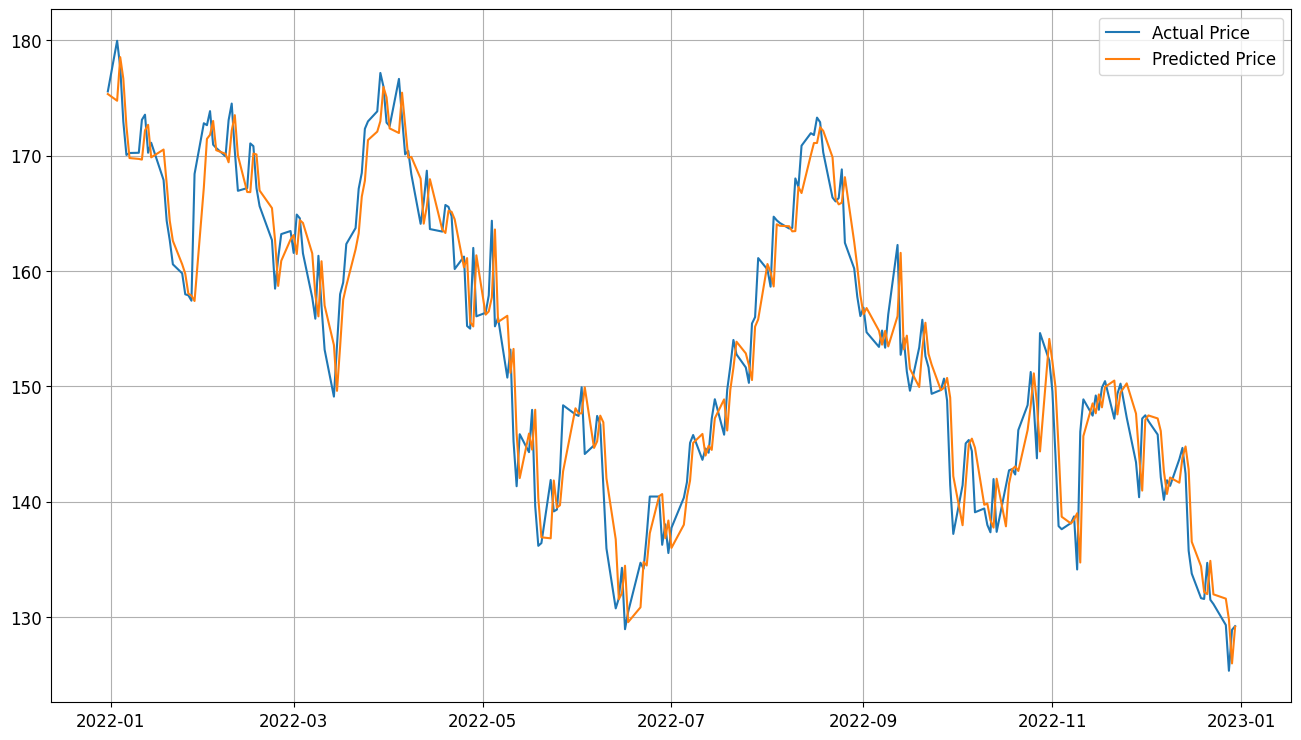

In [86]:
nnet1 = nn.NeuralNetwork(X1_train.shape[1], [20], y1_train.shape[1])

nnet1.train(X1_train, y1_train, X1_val, y1_val, 1000, 'scg', 0.02, momentum=0.9, weight_penalty=0, verbose=False)

train_predictions = nnet1.use(X1_train)
val_predictions = nnet1.use(X1_val)

plt.plot(dates1_val, y1_val, label="Actual Price")
plt.plot(dates1_val, val_predictions, label='Predicted Price')
plt.legend(['Actual Price', 'Predicted Price'])

SCG: Epoch 100 MSE=0.00304,0.01073
SCG: Epoch 200 MSE=0.00302,0.01072
SCG: Epoch 300 MSE=0.00301,0.01074
SCG: Epoch 400 MSE=0.00300,0.01067
SCG: Epoch 500 MSE=0.00300,0.01067
SCG: Epoch 600 MSE=0.00300,0.01066
SCG: Epoch 700 MSE=0.00298,0.01080
SCG: Epoch 800 MSE=0.00296,0.01097
SCG: Epoch 900 MSE=0.00294,0.01099
SCG: Epoch 1000 MSE=0.00292,0.01107


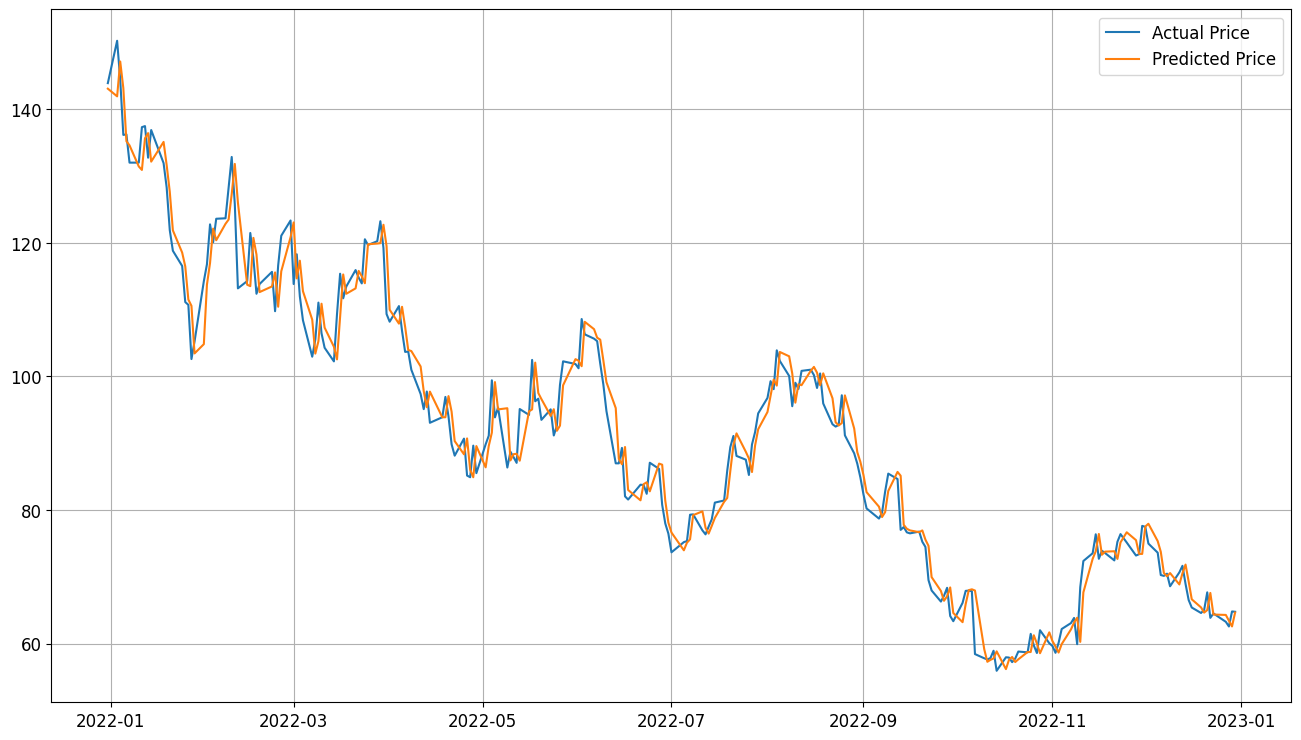

In [88]:
nnet2 = nn.NeuralNetwork(X2_train.shape[1], [20], y2_train.shape[1])

nnet2.train(X2_train, y2_train, X2_val, y2_val, 1000, 'scg', 0.02, momentum=0.9, weight_penalty=0, verbose=False)

train_predictions = nnet2.use(X2_train)
val_predictions = nnet2.use(X2_val)

plt.plot(dates2_val, y2_val, label="Actual Price")
plt.plot(dates2_val, val_predictions, label='Predicted Price')
plt.legend(['Actual Price', 'Predicted Price'])

SCG: Epoch 200 MSE=0.03765,0.10428
SCG: Epoch 400 MSE=0.03613,0.11473
SCG: Epoch 600 MSE=0.03578,0.51957
SCG: Epoch 800 MSE=0.03522,0.19575
SCG: Epoch 1000 MSE=0.03484,0.13985
SCG: Epoch 1200 MSE=0.03454,0.04517
SCG: Epoch 1400 MSE=0.03421,0.06533
SCG: Epoch 1600 MSE=0.03362,0.09085
SCG: Epoch 1800 MSE=0.03312,0.21023
SCG: Epoch 2000 MSE=0.03258,0.15910


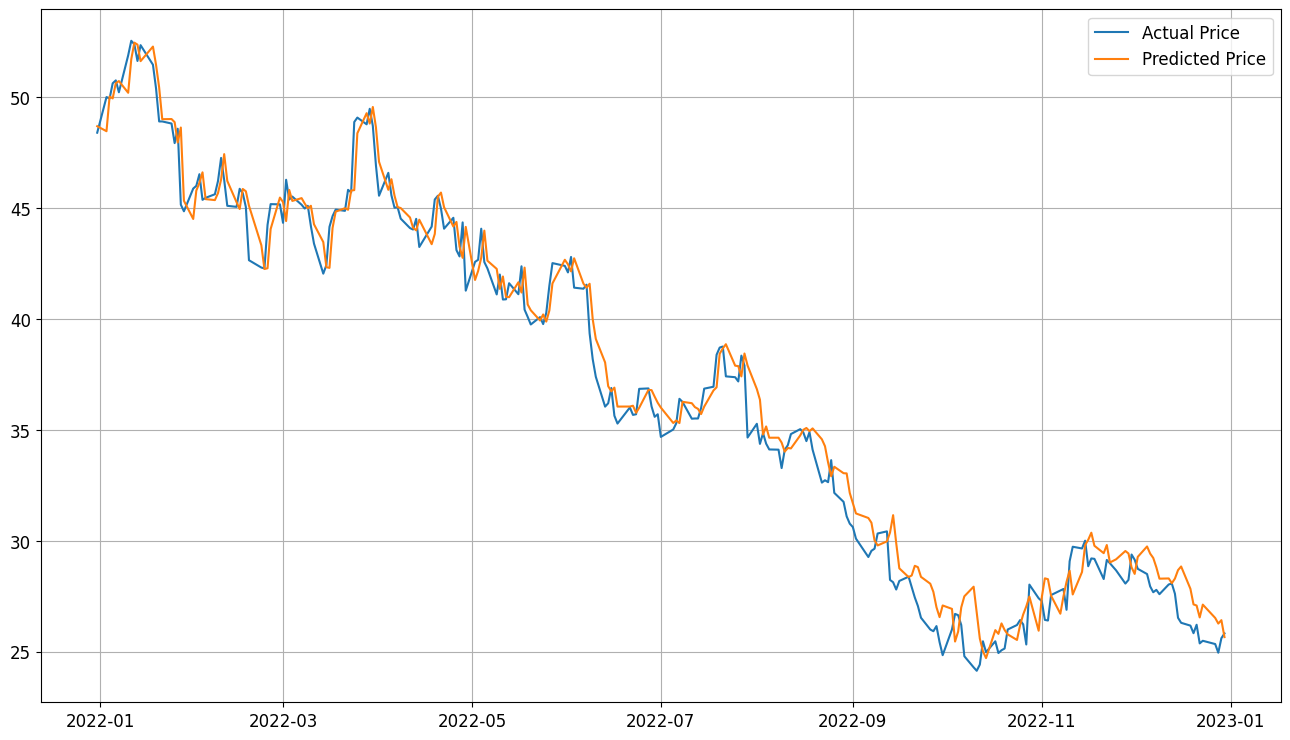

In [92]:
nnet3 = nn.NeuralNetwork(X3_train.shape[1], [20], y3_train.shape[1])

nnet3.train(X3_train, y3_train, X3_val, y3_val, 2000, 'scg', 0.02, momentum=0.9, weight_penalty=0, verbose=False)

train_predictions = nnet3.use(X3_train)
val_predictions = nnet3.use(X3_val)

plt.plot(dates3_val, y3_val, label="Actual Price")
plt.plot(dates3_val, val_predictions, label='Predicted Price')
plt.legend(['Actual Price', 'Predicted Price'])

SCG: Epoch 200 MSE=0.00187,0.00723
SCG: Epoch 400 MSE=0.00185,0.00714
SCG: Epoch 600 MSE=0.00184,0.00710
SCG: Epoch 800 MSE=0.00184,0.00703
SCG: Epoch 1000 MSE=0.00183,0.00701
SCG: Epoch 1200 MSE=0.00183,0.00704
SCG: Epoch 1400 MSE=0.00182,0.00701
SCG: Epoch 1600 MSE=0.00181,0.00706
SCG: Epoch 1800 MSE=0.00181,0.00708
SCG: Epoch 2000 MSE=0.00181,0.00708


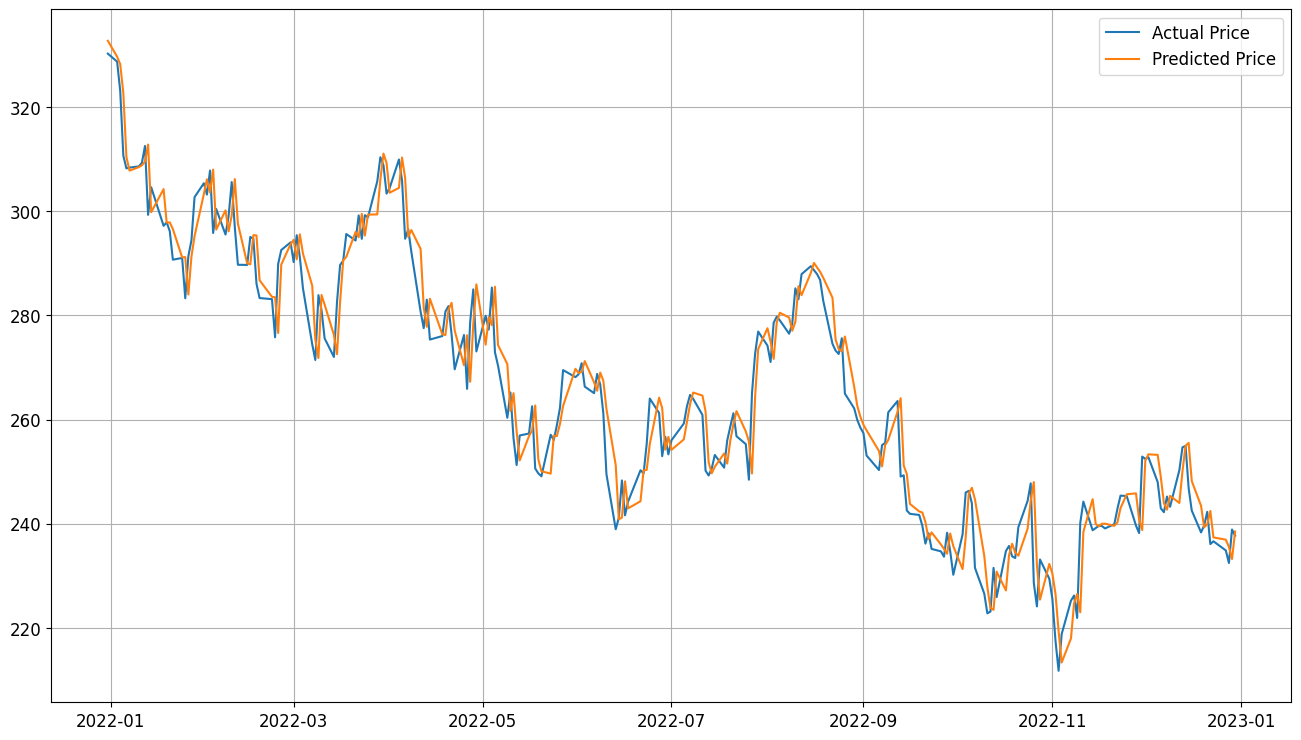

In [94]:
nnet4 = nn.NeuralNetwork(X4_train.shape[1], [20], y4_train.shape[1])

nnet4.train(X4_train, y4_train, X4_val, y4_val, 2000, 'scg', 0.02, momentum=0.9, weight_penalty=0, verbose=False)

train_predictions = nnet4.use(X4_train)
val_predictions = nnet4.use(X4_val)

plt.plot(dates4_val, y4_val, label="Actual Price")
plt.plot(dates4_val, val_predictions, label='Predicted Price')
plt.legend(['Actual Price', 'Predicted Price'])

SCG: Epoch 200 MSE=0.00276,0.01364
SCG: Epoch 400 MSE=0.00274,0.01353
SCG: Epoch 600 MSE=0.00273,0.01364
SCG: Epoch 800 MSE=0.00271,0.01373
SCG: Epoch 1000 MSE=0.00269,0.01376
SCG: Epoch 1200 MSE=0.00260,0.01430
SCG: Epoch 1400 MSE=0.00257,0.01448
SCG: Epoch 1600 MSE=0.00257,0.01451
SCG: Epoch 1800 MSE=0.00256,0.01459
SCG: Epoch 2000 MSE=0.00256,0.01463


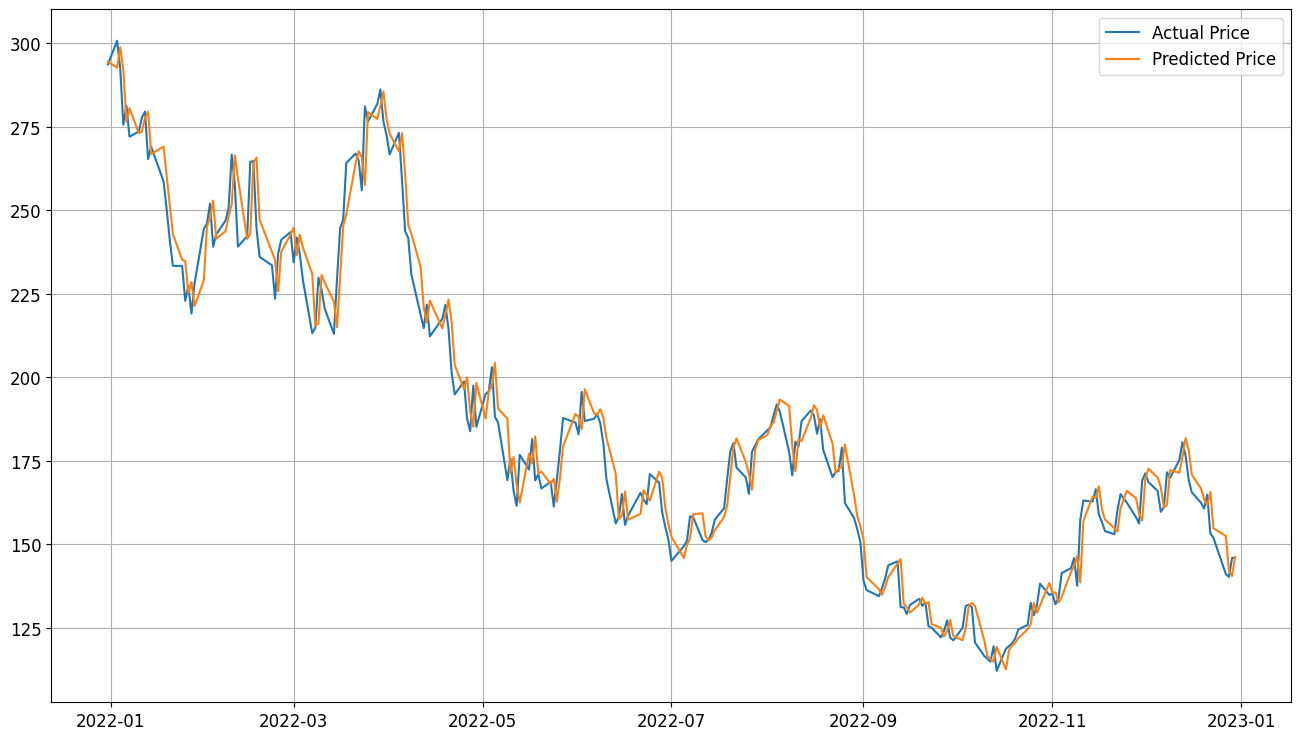

In [95]:
nnet5 = nn.NeuralNetwork(X5_train.shape[1], [20], y5_train.shape[1])

nnet5.train(X5_train, y5_train, X5_val, y5_val, 2000, 'scg', 0.02, momentum=0.9, weight_penalty=0, verbose=False)

train_predictions = nnet5.use(X5_train)
val_predictions = nnet5.use(X5_val)

plt.plot(dates1_val, y5_val, label="Actual Price")
plt.plot(dates1_val, val_predictions, label='Predicted Price')
plt.legend(['Actual Price', 'Predicted Price'])

From the graphs we can observe that predicted price is close to the actual price in all the 5 stocks. The Mean Squared Error (MSE) values for stocks 1 to 5 show the performance of the respective models across different epochs. Lower MSE values indicate better performance, suggesting that the model's predictions are closer to the actual values. Comparing the MSE values among stocks:

* The Stocks Apple, AMD, and Microsoft exhibit relatively low MSE values across epochs, indicating better predictive accuracy and consistency in their models.
* Nvidia stock has higher MSE values compared to Stocks Apple, AMD and Microsoft but lower compared to Stock Intel, suggesting moderate predictive accuracy.
* Stock Intel displays significantly higher MSE values, particularly from Epoch 400 onwards, indicating increased prediction errors and potentially poor model performance for this stock.

## Comparing Multi-layer feedforward neural network model with LSTM model

||RMSE of Multi-layer feedforward neural network model  | RMSE of LSTM model|
| --- | --- | --- |
|Apple     |3.353606 |2.185977|
|AMD       |3.639746 |2.673211|
|Intel     |1.005893 |1.981507|
|Microsoft |5.867722 |3.921960|
|Nvidia    |7.688548 |4.650117|

Comparing the RMSE values between the multi-layer feedforward neural network model and the LSTM model:

* For Apple, both models have relatively low RMSE values, but the LSTM model outperforms the multi-layer feedforward neural network.
* In the case of AMD, the LSTM model shows a lower RMSE, indicating better performance compared to the multi-layer feedforward neural network.
* Intel's stock predictions showcase a substantially better RMSE with the multi-layer feedforward neural network compared to the LSTM model.
* Microsoft's stock predictions demonstrate significant improvement with the LSTM model, displaying notably lower RMSE values compared to the multi-layer feedforward neural network.
* Nvidia's stock predictions also exhibit better performance with the LSTM model, showcasing lower RMSE values compared to the multi-layer feedforward neural network.

In summary, the LSTM model generally performs better for AMD, Microsoft, and Nvidia stocks, while the multi-layer feedforward neural network excels for Intel's stock predictions. The choice of model superiority depends on the specific stock and its nuances in price prediction. LSTM (Long Short-Term Memory) models excel in capturing and leveraging temporal dependencies and long-range sequences. They are adept at retaining and utilizing past information, making them suitable for stock prediction tasks where historical trends significantly impact future prices. Stocks often exhibit complex patterns and dependencies over time, and LSTM's ability to learn from long-term sequences likely contributed to its superior performance for most stocks by effectively capturing nuanced relationships and temporal dynamics in the data.

In [1]:
import io
import nbformat
import glob

# Get a list of all ipynb files in the current directory
nbfile = glob.glob('Using_A3_Final.ipynb')

# Check if there is at least one ipynb file
if len(nbfile) > 0:
    with io.open(nbfile[0], 'r', encoding='utf-8') as f:
        nb = nbformat.read(f, nbformat.NO_CONVERT)
    word_count = 0
    for cell in nb.cells:
        if cell.cell_type == "markdown":
            word_count += len(cell['source'].replace('#', '').lstrip().split(' '))
    print('Word count for file', nbfile[0], 'is', word_count)
else:
    print('No ipynb files found with the specified name.')

Word count for file Using_A3_Final.ipynb is 1853
